In [1]:
%load_ext autoreload
%autoreload 2
import warnings; warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
# Python dependences
import os, time
import numpy as np   # Numpy - Python's numerical library
import matplotlib.pyplot as plt  # Matplotlib - Python's plotting library
from copy import deepcopy   # Python module for copying objects

# Input and Output Tools
# Catalogue and sources 
from hmtk.parsers.catalogue import CsvCatalogueParser   # Reads an earthquake catalogue from CSV
from hmtk.parsers.catalogue.csv_catalogue_parser import CsvCatalogueWriter  # Writes an earthquake catalogue to CSV
from hmtk.parsers.source_model.nrml04_parser import nrmlSourceModelParser  # Imports a source model from XML

# Plotting tools
from hmtk.plotting.mapping import HMTKBaseMap
from hmtk.plotting.seismicity.completeness import plot_stepp_1972
from hmtk.plotting.seismicity.catalogue_plots import plot_magnitude_time_scatter
from hmtk.plotting.seismicity.catalogue_plots import plot_depth_histogram
from hmtk.plotting.seismicity.catalogue_plots import plot_magnitude_time_density
from hmtk.plotting.seismicity.max_magnitude.cumulative_moment import plot_cumulative_moment 
from hmtk.plotting.seismicity.catalogue_plots import (plot_observed_recurrence, 
                                                      get_completeness_adjusted_table,
                                                      _get_catalogue_bin_limits)
from hmtk.plotting.seismicity.occurrence.recurrence_plot import plot_recurrence_model
# Recurrence and Mmax
from hmtk.seismicity.occurrence.kijko_smit import KijkoSmit
from hmtk.seismicity.occurrence.weichert import Weichert
from hmtk.seismicity.max_magnitude.kijko_sellevol_bayes import KijkoSellevolBayes
from hmtk.seismicity.max_magnitude.kijko_sellevol_fixed_b import KijkoSellevolFixedb
from hmtk.seismicity.max_magnitude.kijko_nonparametric_gaussian import KijkoNonParametricGaussian
from hmtk.seismicity.max_magnitude.cumulative_moment_release import CumulativeMoment
from hmtk.plotting.seismicity.max_magnitude.cumulative_moment import plot_cumulative_moment

# Catalogue selector - we will see this in action
from hmtk.seismicity.selector import CatalogueSelector

from openquake.hazardlib.mfd import TruncatedGRMFD

print("Everything Imported OK!")

Everything Imported OK!


In [3]:
# Indicate Depth
Depth = "Deep" # Shallow, MidCrust, Deep

catalogue_file = "input_data/Overall_Seismicity_Dec_" + Depth + "_2021.11.16.csv"
parser = CsvCatalogueParser(catalogue_file)
catalogue = parser.read_file(start_year=1619)

# Load in a Source Model File

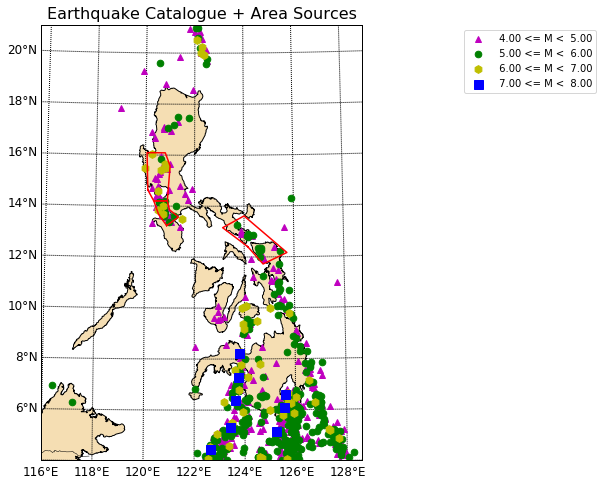

In [4]:
source_model_file = "input_data/AreaSource_" + Depth + ".xml"

parser = nrmlSourceModelParser(source_model_file)

# Parse the seismic sources and save them into a variable called "source_model"
source_model = parser.read_file("AreaSource_" + Depth) # You need to supply a name for the source model

llon, ulon, llat, ulat = catalogue.get_bounding_box()
map_config = {'min_lon': np.floor(llon), 'max_lon': np.ceil(ulon),
              'min_lat': np.floor(llat), 'max_lat': np.ceil(ulat), 'resolution':'i'}

basemap1 = HMTKBaseMap(map_config, 'Earthquake Catalogue + Area Sources')
# Adding the catalogue to the basemap
basemap1.add_catalogue(catalogue, overlay=True)
# Adding the seismic sources
basemap1.add_source_model(source_model, area_border='r-', border_width=1.5, alpha=0.5) 

### A Source Model Workflow - Area Source Example

Each of the area sources has:

1. Defined name, ID, tectonic region type

2. Geometry (polygon)

3. Magnitude Scaling Relation (Wells & Coppersmith, 1994)

4. Rupture Aspect Ratio (1.5)

5. Nodal Plane Distribution (varies)


But they are missing the magnitude frequency distribution and the hypocentral depth distribution!

Using the observed catalogue - define the MFD as a Truncated Gutenberg-Richer model for each source

Assume $M_{MIN} = 4.8$

Completeness: ok


Completeness table using Stepp method (1971)
[[1970.     4.5]
 [1970.     4.6]
 [1964.     4.7]
 [1922.     4.8]
 [1922.     4.9]
 [1922.     5. ]
 [1922.     5.1]
 [1922.     5.2]
 [1922.     5.3]
 [1922.     5.4]
 [1922.     5.5]
 [1922.     5.6]
 [1922.     5.7]
 [1922.     5.8]
 [1922.     5.9]
 [1922.     6. ]
 [1922.     6.1]
 [1922.     6.2]
 [1922.     6.3]
 [1922.     6.4]
 [1887.     6.5]
 [1887.     6.6]
 [1887.     6.7]
 [1868.     6.8]
 [1868.     6.9]
 [1868.     7. ]
 [1868.     7.1]
 [1868.     7.2]
 [1868.     7.3]
 [1868.     7.4]
 [1868.     7.5]
 [1868.     7.6]]




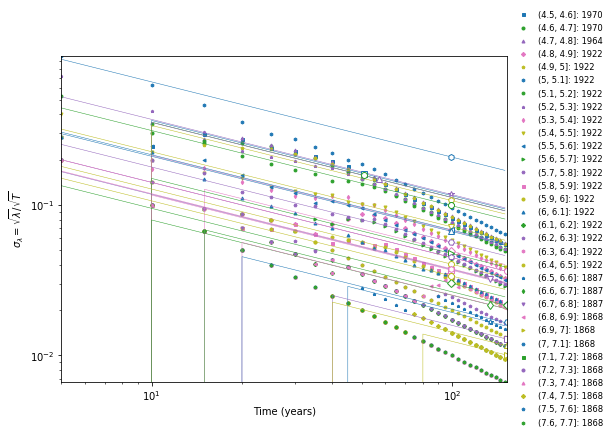

In [5]:
from openquake.hmtk.seismicity.completeness.comp_stepp_1971 import Stepp1971
# Set up the configuration parameters
comp_config = {'magnitude_bin': 0.1, 'time_bin': 5.0, 'increment_lock': True}

# Calling the method by Stepp (1971)
completeness_algorithm = Stepp1971()

# Use the catalogue and completeness configuration
completeness_table = completeness_algorithm.completeness(catalogue, comp_config)
print('Completeness: ok')

# Print the completeness table
print('\n')
print('Completeness table using Stepp method (1971)')
print(completeness_table)
print('\n')

# Setting configuration for the completeness plot
completeness_parameters = completeness_algorithm
output_file = "output_data/" + Depth + "_Completeness_Overall_Plot.png"
if os.path.exists(output_file):
    os.remove(output_file)

plot_stepp_1972.create_stepp_plot(completeness_parameters, figure_size=(8, 6), 
                                  filename=output_file, filetype='png', dpi=300, ax=None)

In [6]:
# truncate catalogue to years 1900 and above for plotting

cat_dec_plot = deepcopy(catalogue)
cat_years = cat_dec_plot.data['year']
cat_mon = cat_dec_plot.data['month']
cat_day = cat_dec_plot.data['day']
cat_hr = cat_dec_plot.data['hour']
cat_min = cat_dec_plot.data['minute']
cat_sec = cat_dec_plot.data['second']
cat_mags = cat_dec_plot.data['magnitude']

#cat_recent_years = cat_years >= 1619
cat_recent_years = cat_years >= 1900
cat_dec_plot.data['year'] = cat_years[cat_recent_years]
cat_dec_plot.data['month'] = cat_mon[cat_recent_years]
cat_dec_plot.data['day'] = cat_day[cat_recent_years]
cat_dec_plot.data['hour'] = cat_hr[cat_recent_years]
cat_dec_plot.data['minute'] = cat_min[cat_recent_years]
cat_dec_plot.data['second'] = cat_sec[cat_recent_years]
cat_dec_plot.data['magnitude'] = cat_mags[cat_recent_years]

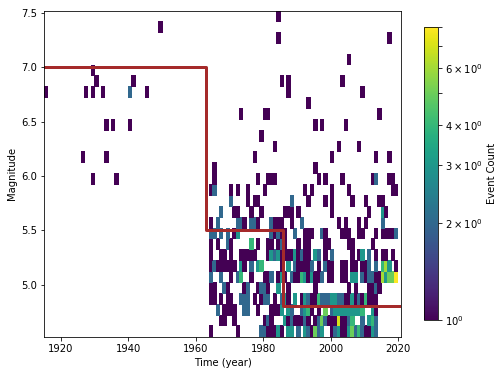

In [7]:
#SHALLOW
# completeness_table = np.array([[1980, 4.8],
#                               [1964, 5.0],
#                               [1955, 5.8],
#                               [1943, 6.2],
#                               [1930, 6.7],
#                               [1920, 7.0],
#                               [1863, 7.5],
#                               [1619, 8.2]])

#MID CRUST
# completeness_table = np.array([[1976, 4.8],
#                               [1963, 5.0],
#                               [1957, 5.9],
#                               [1949, 6.6],
#                               [1903, 7.0],
#                               [1884, 7.2],
#                               [1852, 7.6]])

#DEEP
completeness_table = np.array([[1986, 4.8],
                               [1963, 5.5],
                               [1871, 7.0]])

plot_magnitude_time_density(cat_dec_plot, 0.1, 1.0,
                            completeness=completeness_table)

min_mag = 4.8

selector1 = CatalogueSelector(catalogue, create_copy=True)

In the following workflow we will, for each source:

1. Select the earthquakes within the source

2. Plot them on a map

3. Use them to calculate a- and b-value from the Weichert (1980) method

4. Estimate Mmax using the cumulative moment method (plus a small offset)

5. View the hypocentral depth distribution - and use the density to define the hypocentral depth distribution for the source

----------------------------------------------------------------------------
Source ID: 14B  Source Name: Deep MT2   Number of Events: 22
a = 1.647 (+/- 0.125),  b = 0.489 (+/-0.262)
Mmax (Observed) = 6.85 Mmax (Inferred) = 7.139 +/- 0.134


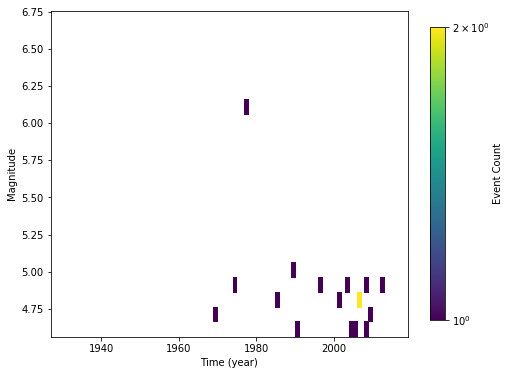

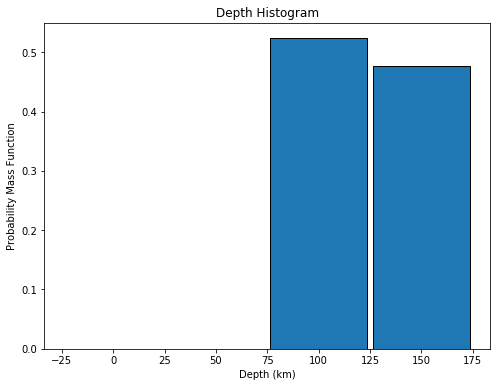

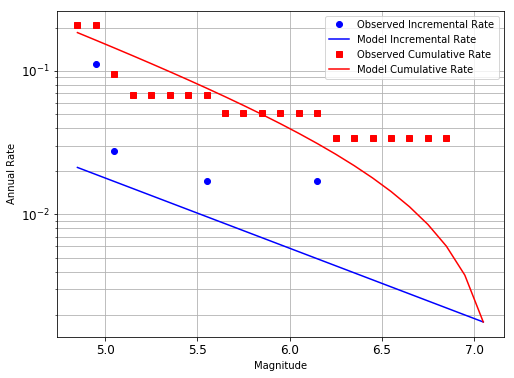

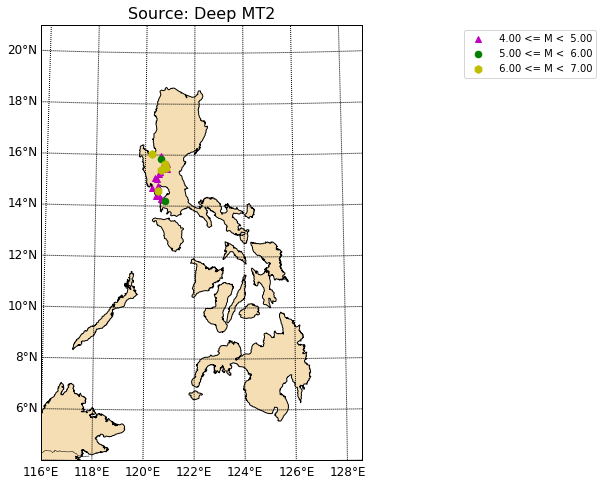

----------------------------------------------------------------------------
Source ID: 14C  Source Name: Deep MT3   Number of Events: 42
a = 2.028 (+/- 0.084),  b = 0.487 (+/-0.174)
Mmax (Observed) = 6.70 Mmax (Inferred) = 7.121 +/- 0.226


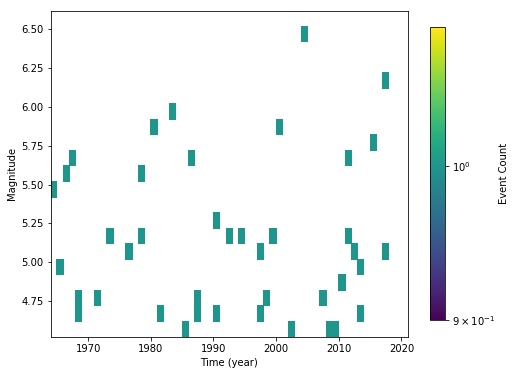

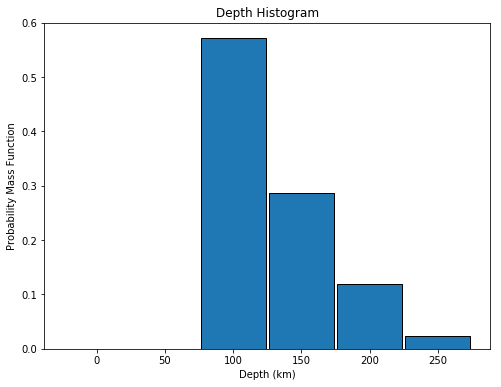

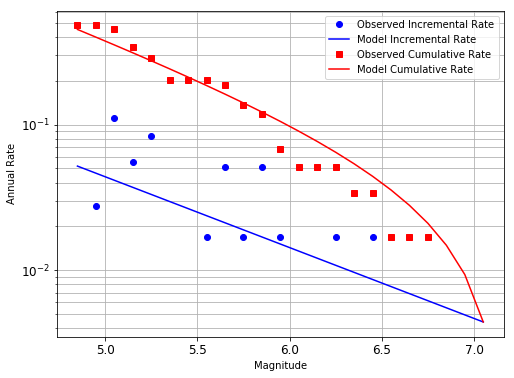

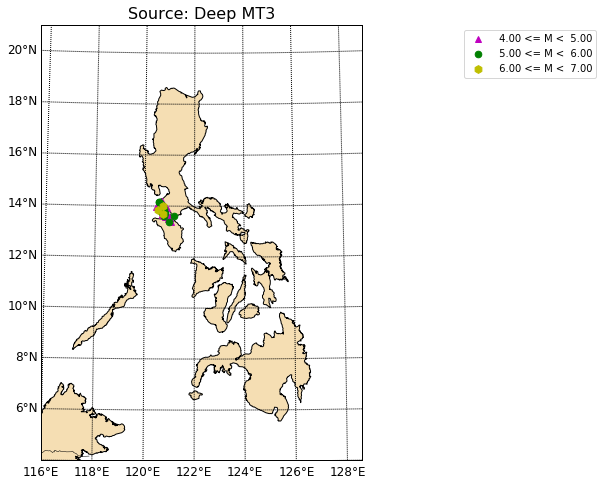

----------------------------------------------------------------------------
Source ID: 15A  Source Name: Deep PT1   Number of Events: 17
a = 1.063 (+/- 0.139),  b = 0.381 (+/-0.550)
Mmax (Observed) = 5.77 Mmax (Inferred) = 6.090 +/- 0.295


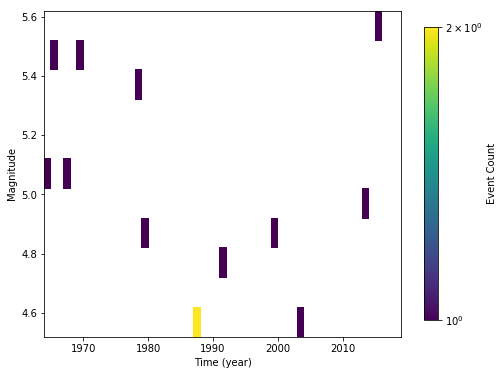

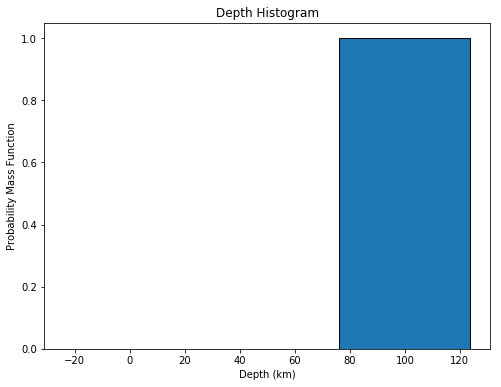

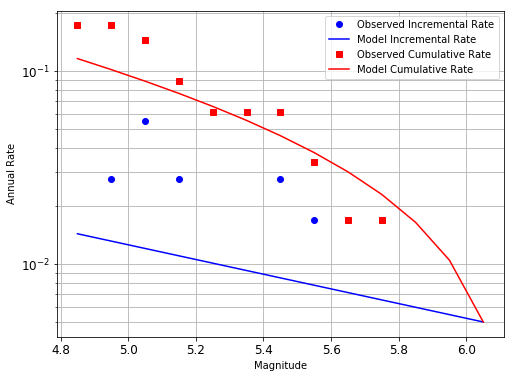

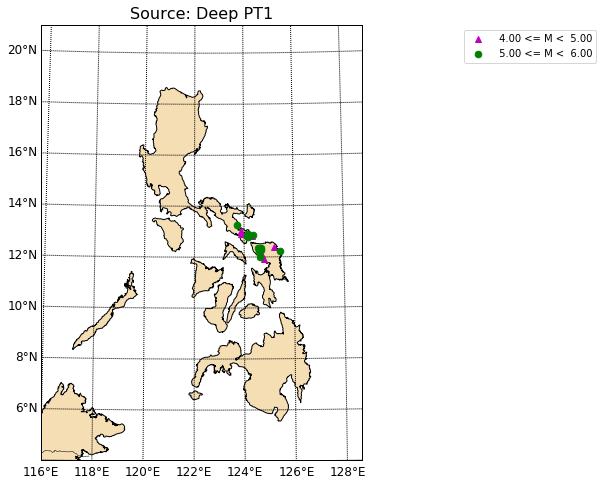

In [8]:
IdDict = {"Shallow" : ['1', '2', '3', '4', '5', '6A', '6B', '6C', '7', '8', '9', '10'],
          "MidCrust" : ['11A', '11B', '11C', '12', '13A'],
          "Deep" : ['14B', '14C', '15A']}


IdList = IdDict[Depth]

aList = []
sigma_aList = []
bList = []
sigma_bList = []

for source in source_model.sources:

    print('----------------------------------------------------------------------------')
    # Select the earthquakes within the source
    source.select_catalogue(selector1)
    print("Source ID: %s  Source Name: %s   Number of Events: %g" % (source.id, source.name,
                                                                     source.catalogue.get_number_events()))

    # Get the a- and b-value using Weichert (1980)
    occurrence = Weichert()
    recurrence_config = {"magnitude_interval": 0.1}
    bval, sigma_b, aval, sigma_a = occurrence.calculate(source.catalogue,
                                                        recurrence_config,
                                                        completeness_table)
    print("a = %.3f (+/- %.3f),  b = %.3f (+/-%.3f)" % (aval, sigma_a, bval, sigma_b))
    aList.append(aval)
    sigma_aList.append(sigma_a)
    bList.append(bval)
    sigma_bList.append(sigma_b)

    # Estimate the Maximum Magnitude - using the Cumulative Moment Method
    # mmax_config = {"number_bootstraps": 500}
    # mmax_calculator = CumulativeMoment()
    
    # Estimate the Maximum Magnitude - using the Kijko Non-Parametric Gaussian Approach
    mmax_config = {"input_mmin": 4.8,
                  "input_mmax": None, # It will take the maximum observed magnitude in the catalogue
                  "input_mmax_uncertainty": None, # It will take the uncertainty of the maximum observed in the catalogue
                  "b-value": bval,
                  "sigma-b": sigma_b,
                  "number_earthquakes": 5}
    mmax_calculator = KijkoNonParametricGaussian()
    
    mmax, sigma_mmax = mmax_calculator.get_mmax(source.catalogue, mmax_config)
    print("Mmax (Observed) = %.2f Mmax (Inferred) = %.3f +/- %.3f" % ( 
        np.max(source.catalogue.data["magnitude"]), mmax + 0.2, sigma_mmax))
    
    # Compare the model against data
    source.mfd = TruncatedGRMFD(min_mag, mmax + 0.2, 0.1, aval, bval)

    plot_magnitude_time_density(source.catalogue, 0.1, 1.0)
    
    if source.id in IdList:
        
        
        
        # Show the depth histogram
        if Depth == "Deep": depth_interval = 50  # in km
        else: depth_interval = 25  # in km
        # 50-70 deep; 25 otherwise
 


        plot_depth_histogram(source.catalogue, depth_interval, normalisation=True)
        plot_recurrence_model(source.mfd, source.catalogue, completeness_table, 0.1)
    
        # Add the probability mass function of the hypocentre depths to the source
        depth_bins = np.arange(source.upper_depth,
                               source.lower_depth + depth_interval,
                               depth_interval)
        source.hypo_depth_dist = source.catalogue.get_depth_pmf(depth_bins)
        # Wait for the plotting to catch up!
        
        # Map the Source
        src_basemap = HMTKBaseMap(map_config, "Source: {:s}".format(source.name))
        # Add on the catalogue
        src_basemap.add_catalogue(source.catalogue)

    time.sleep(1.0)

In [9]:
source_model.serialise_to_nrml("output_data/AreaSource_" + Depth + ".xml")

In [10]:
# for single copying of values to table in report
import sys
original_stdout = sys.stdout
with open("output_data/a_b_table_" + Depth + ".txt", "w") as f:
    sys.stdout = f
    print("a\tsigma_a\tb\tsigma_b")
    for i, a in enumerate(aList):
        print("%.3f\t%.3f\t%.3f\t%.3f" % (a, sigma_aList[i], bList[i], sigma_bList[i]))
    sys.stdout = original_stdout

# ----- STOP HERE -----

### Exploring Fault Sources in the Gulf of Corinth

In [ ]:
fault_model_file = "input_data/source_models/GulfOfCorinth_minimal.xml"
parser = nrmlSourceModelParser(fault_model_file)
fault_sources = parser.read_file("Gulf of Corinth Faults")

#### Visualise

In [ ]:
map_config = {'min_lon': 20.9, 'max_lon': 24.0,
              'min_lat': 37.5, 'max_lat': 39.0, 'resolution':'h'}

# Map the Source
src_basemap = HMTKBaseMap(map_config, "Gulf of Corinth Faults & Seismicity")
# Add on the catalogue
src_basemap.add_catalogue(catalogue, overlay=True)
src_basemap.add_source_model(fault_sources)